# Udacity CarND Project 5 - Vehicle Detection

## Import required packages

In [113]:
import glob
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Load filenames and get number of car and no car classes

In [ ]:
def load_filenames():
    cwd = os.getcwd()
    cars = []
    notcars = []
    cars = glob.glob(cwd + '/vehicles/KITTI_extracted/*.png')
    cars.extend(glob.glob(cwd + '/vehicles/GTI_Far/*.png'))
    cars.extend(glob.glob(cwd + '/vehicles/GTI_Left/*.png'))
    cars.extend(glob.glob(cwd + '/vehicles/GTI_MiddleClose/*.png'))
    cars.extend(glob.glob(cwd + '/vehicles/GTI_Right/*.png'))

    notcars = glob.glob(cwd + '/non-vehicles/Extras/*.png')
    notcars.extend(glob.glob(cwd + '/non-vehicles/GTI/*.png'))
    return [cars, notcars]

In [ ]:
fn = load_filenames()
num_c = len(fn[0])
num_nc = len(fn[1])
fname_list = fn[0] + fn[1]
print(len(fname_list))
print(num_c)
print(num_nc)
del fn

## Functions to create hog features, spacial features and color histogram features

In [ ]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                     block_norm='L2-Hys', feature_vec=True):
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec, block_norm = block_norm)
    return features


# Define a function to compute binned color features  
def bin_spatial(img, size=(8, 8)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 1)):
    img = cv2.resize(img, (8,8))
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    
    return hist_features


## Generate feature list from given image

In [ ]:
# Define a function to extract features from an RGB image
# Have this function call bin_spatial() and color_hist()
def extract_features(image):
    # Create a list to append feature vectors to

    spac_feat = bin_spatial(image)
    color_hist_feat = color_hist(image)
    
    feature_image = np.copy(image)
    feature_image = cv2.resize(cv2.cvtColor(feature_image, cv2.COLOR_RGB2YUV), (64,64))
    feature_image_gray = cv2.resize(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), (64,64))
    # Apply HOG features
    hog_feat = []
    for channel in range(feature_image.shape[2]):
        hog_feat.append(get_hog_features(feature_image[:,:,channel]))
        
    hog_feat.append(get_hog_features(feature_image_gray))
    hog_feat = np.ravel(hog_feat) 

    # Return list of feature vectors
    feat = np.hstack((spac_feat, color_hist_feat))
    feat = np.hstack((feat, hog_feat))
    
    return feat

## Load images and generate feature array and class vector

In [ ]:
y = np.hstack((np.ones(num_c), np.zeros(num_nc)))

for i in range(num_c+num_nc):
    img = mpimg.imread(fname_list[i])
    if i == 0:
        X_raw = extract_features(img)
    else:  
        nv = extract_features(img)
        X_raw = np.vstack((X_raw, nv))
    if i%500 == 0:
        print(i, ' of ', len(fname_list))
print(X_raw.shape)

pickle.dump(X_raw, open("X_raw.p", "wb"))
pickle.dump(y, open("y.p", "wb"))

## Train and save feature normalizer and classifier

In [ ]:
X_raw = pickle.load( open("X_raw.p", "rb"))
X_raw = pickle.load( open("X_raw.p", "rb"))

X_raw, y = shuffle(X_raw, y)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2)
X_scaler = StandardScaler().fit(X_train)

clf = LinearSVC(C=0.01).fit(X_scaler.transform(X_train), y_train)

accuracy = clf.score(X_scaler.transform(X_test), y_test)
y_pred = clf.predict(X_scaler.transform(X_test))
cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

pickle.dump(X_scaler, open("X_scaler.p", "wb"))
pickle.dump(clf, open("clf.p", "wb"))

## Define hmap class for use in storing rolling heatmap

In [114]:
class hmap():
    def __init__(self):
        self.vals = np.zeros((720, 1280, 3))
    def update(self, new_values, alpha):
        self.vals = (1 - alpha) * self.vals + alpha * new_values
        

## Add windows, but with only calling the HOG function once and minimize resizing

In [115]:
def add_windows_fast(img, draw_img, window, ystart=400, nysteps=1):
    
    draw_img = np.copy(draw_img)
    nblocks_per_window = 8
    
    nbins=32
    bins_range=(0, 1)
    
    width = img.shape[1]
    dx = round(window/4)
    dy = round(window/4)
    
    xstart = np.int(width / 2)
    
    nxsteps = np.int((width / 2 - window) / dx) + 1
    img_width = np.int(window + (nxsteps - 1) * dx)
    
    xstop = np.int(xstart + img_width)
    img_height = np.int(window + dy * (nysteps - 1))
    ystart = np.int(ystart)
    ystop = np.int(ystart + img_height)
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    cells_per_step = 2
    num_cells_x = nblocks_per_window + cells_per_step * (nxsteps - 1)
    scale = np.int(img_width/num_cells_x/8)
    
    
    size_64 = cv2.resize(img_tosearch, (img_width // scale, img_height // scale))
    size_8 = cv2.resize(img_tosearch, (img_width // scale // 8, img_height // scale // 8))
    
    size_64_YUV = cv2.cvtColor(cv2.resize(img_tosearch,
                                          (img_width // scale, img_height // scale)), cv2.COLOR_RGB2YUV)
    size_64gray = cv2.cvtColor(cv2.resize(img_tosearch,
                                          (img_width // scale, img_height // scale)), cv2.COLOR_RGB2GRAY)
    
    hogch0 = hog(size_64_YUV[:,:,0], orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2,2), transform_sqrt=False, 
                       visualise=False, feature_vector=False, block_norm = 'L2-Hys')
    hogch1 = hog(size_64_YUV[:,:,1], orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2,2), transform_sqrt=False, 
                       visualise=False, feature_vector=False, block_norm = 'L2-Hys')
    hogch2 = hog(size_64_YUV[:,:,2], orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2,2), transform_sqrt=False, 
                       visualise=False, feature_vector=False, block_norm = 'L2-Hys')
    
    hogchg = hog(size_64gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2,2), transform_sqrt=False, 
                       visualise=False, feature_vector=False, block_norm = 'L2-Hys')
    
    box_list = []
    dist_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            xcfpos = xb * 2
            ycfpos = yb * 2
            
            hog_0 = hogch0[ypos:ypos+7, xpos:xpos+7].ravel() 
            hog_1 = hogch1[ypos:ypos+7, xpos:xpos+7].ravel() 
            hog_2 = hogch2[ypos:ypos+7, xpos:xpos+7].ravel() 
            hog_g = hogchg[ypos:ypos+7, xpos:xpos+7].ravel() 
            
            hog_features = np.hstack((hog_0, hog_1, hog_2, hog_g))

            # Extract the image patch
            subimg = size_8[ycfpos:ycfpos+8, xcfpos:xcfpos+8,:]        
            spatial_features = subimg.ravel() 
            
            # Compute the histogram of the color channels separately
            channel1_hist = np.histogram(subimg[:,:,0], bins=nbins, range=bins_range)
            channel2_hist = np.histogram(subimg[:,:,1], bins=nbins, range=bins_range)
            channel3_hist = np.histogram(subimg[:,:,2], bins=nbins, range=bins_range)
            # Concatenate the histograms into a single feature vector
            hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
            
            # Scale features and make a prediction
            test_features_raw = np.hstack((spatial_features, hist_features, hog_features))
            test_features = X_scaler.transform(test_features_raw.reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            df = svc.decision_function(test_features)

            if test_prediction == 1 and df[0]>0:
                xbox_left = np.int(xpos*scale*8)
                ytop_draw = np.int(ypos*scale*8)
                win_draw = np.int(window)
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),
                              (xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart),(0,0,df[0]/3),6)
                box_list.append(((xbox_left+xstart, ytop_draw+ystart),
                              (xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart)))
                dist_list.append(df)
    return draw_img, box_list, dist_list

## Find cars and display both car bound and internal windows

In [164]:
def find_cars_fast(img): 

    img = img.astype(np.float32)/255
    #draw_image = add_windows_fast(img=img, draw_img=img, window=256, ystart = 680-256*5/4, nysteps = 2)
    #draw_image = add_windows_fast(img=img, draw_img=img, 
    #                              window=192, ystart = 700-192*7/4, nysteps = 4) 
    draw_image, box_list128, dist_list128 = add_windows_fast(img=img, draw_img=img, 
                                  window=128, ystart = 392, nysteps = 4) 
    #draw_image = add_windows_fast(img=img, draw_img=draw_image, 
    #                              window=96, ystart = 392, nysteps = 4)
    draw_image, box_list64, dist_list64 = add_windows_fast(img=img, draw_img=draw_image,
                                  window=64, ystart = 392, nysteps = 3) 
    draw_image = draw_image*255
    box_list = box_list128 + box_list64
    dist_list = dist_list128 + dist_list64
    heatmap = np.zeros_like(draw_image)
    for box, dist in zip(box_list, dist_list):
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += dist*dist
    
    min_threshold = 1.5
    max_threshold = 2.5

    heatmap[heatmap>=max_threshold] = max_threshold
    hm.update(heatmap, 0.05)
    
    heatdisp = np.copy(hm.vals) 
    
    heatdisp[heatdisp<=min_threshold] = 0
    
    heatdisp = heatdisp
    labels = label(heatdisp)
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(draw_image, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return draw_image

## Test performance on test images

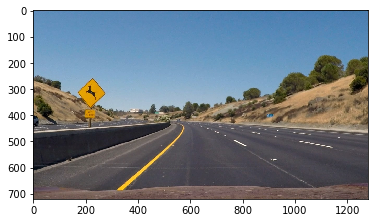

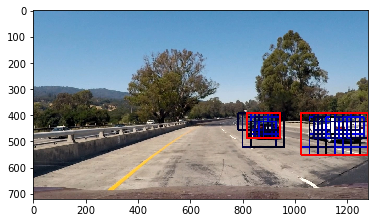

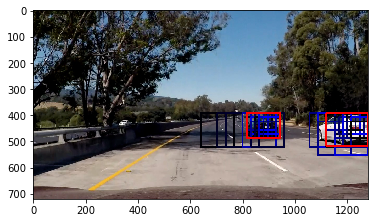

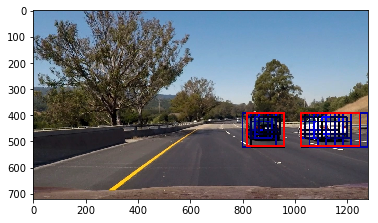

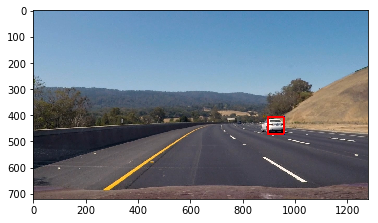

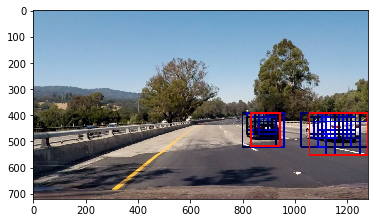

In [161]:
cwd = os.getcwd()
img_list = glob.glob(cwd + '/test_images/*.jpg')

global svc
global X_scaler
global hm 
hm = hmap()

svc = pickle.load( open("clf.p", "rb" ) )
X_scaler = pickle.load( open("X_scaler.p", "rb"))

for img_file in img_list:
    img = mpimg.imread(img_file)
    out_img= find_cars_fast(img=img)*255
    plt.imshow(out_img)
    plt.show()

## Generate video showing both input windows and bounding boxes

In [163]:
# Import everything needed to edit/save/watch video clips
cwd = os.getcwd()
svc = pickle.load( open("clf.p", "rb" ) )
X_scaler = pickle.load( open("X_scaler.p", "rb"))
global hm 
hm = hmap()
project_output_file = cwd + '/output_images/video_output.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False)
project_clip = clip1.fl_image(find_cars_fast)
%time project_clip.write_videofile(project_output_file, audio=False)


MoviePy: building video file /home/brian/PycharmProjects/CarND-Vehicle-Detection-master/output_images/video_output.mp4
----------------------------------------

Writing video into /home/brian/PycharmProjects/CarND-Vehicle-Detection-master/output_images/video_output.mp4
Done writing video in /home/brian/PycharmProjects/CarND-Vehicle-Detection-master/output_images/video_output.mp4 !
Your video is ready !
CPU times: user 6min 36s, sys: 1.73 s, total: 6min 38s
Wall time: 6min 42s


## Generate windows and return only box and svc distances

In [144]:
def add_windows_faster(img, window, ystart=400, nysteps=1):
    
    nblocks_per_window = 8
    
    nbins=32
    bins_range=(0, 1)
    
    width = img.shape[1]
    dx = round(window/4)
    dy = round(window/4)
    
    xstart = np.int(width / 2)
    
    nxsteps = np.int((width / 2 - window) / dx) + 1
    img_width = np.int(window + (nxsteps - 1) * dx)
    
    xstop = np.int(xstart + img_width)
    img_height = np.int(window + dy * (nysteps - 1))
    ystart = np.int(ystart)
    ystop = np.int(ystart + img_height)
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    cells_per_step = 2
    num_cells_x = nblocks_per_window + cells_per_step * (nxsteps - 1)
    scale = np.int(img_width/num_cells_x/8)
    
    
    size_64 = cv2.resize(img_tosearch, (img_width // scale, img_height // scale))
    size_8 = cv2.resize(img_tosearch, (img_width // scale // 8, img_height // scale // 8))
    
    size_64_YUV = cv2.cvtColor(cv2.resize(img_tosearch,
                                          (img_width // scale, img_height // scale)), cv2.COLOR_RGB2YUV)
    size_64gray = cv2.cvtColor(cv2.resize(img_tosearch,
                                          (img_width // scale, img_height // scale)), cv2.COLOR_RGB2GRAY)
    
    hogch0 = hog(size_64_YUV[:,:,0], orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2,2), transform_sqrt=False, 
                       visualise=False, feature_vector=False, block_norm = 'L2-Hys')
    hogch1 = hog(size_64_YUV[:,:,1], orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2,2), transform_sqrt=False, 
                       visualise=False, feature_vector=False, block_norm = 'L2-Hys')
    hogch2 = hog(size_64_YUV[:,:,2], orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2,2), transform_sqrt=False, 
                       visualise=False, feature_vector=False, block_norm = 'L2-Hys')
    
    hogchg = hog(size_64gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2,2), transform_sqrt=False, 
                       visualise=False, feature_vector=False, block_norm = 'L2-Hys')
    
    box_list = []
    dist_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            xcfpos = xb * 2
            ycfpos = yb * 2
            
            hog_0 = hogch0[ypos:ypos+7, xpos:xpos+7].ravel() 
            hog_1 = hogch1[ypos:ypos+7, xpos:xpos+7].ravel() 
            hog_2 = hogch2[ypos:ypos+7, xpos:xpos+7].ravel() 
            hog_g = hogchg[ypos:ypos+7, xpos:xpos+7].ravel() 
            
            hog_features = np.hstack((hog_0, hog_1, hog_2, hog_g))

            # Extract the image patch
            subimg = size_8[ycfpos:ycfpos+8, xcfpos:xcfpos+8,:]        
            spatial_features = subimg.ravel() 
            
            # Compute the histogram of the color channels separately
            channel1_hist = np.histogram(subimg[:,:,0], bins=nbins, range=bins_range)
            channel2_hist = np.histogram(subimg[:,:,1], bins=nbins, range=bins_range)
            channel3_hist = np.histogram(subimg[:,:,2], bins=nbins, range=bins_range)
            # Concatenate the histograms into a single feature vector
            hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
            
            # Scale features and make a prediction
            test_features_raw = np.hstack((spatial_features, hist_features, hog_features))
            test_features = X_scaler.transform(test_features_raw.reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            df = svc.decision_function(test_features)

            if test_prediction == 1 and df[0]>0:
                xbox_left = np.int(xpos*scale*8)
                ytop_draw = np.int(ypos*scale*8)
                win_draw = np.int(window)
                box_list.append(((xbox_left+xstart, ytop_draw+ystart),
                              (xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart)))
                dist_list.append(df)
    return box_list, dist_list

## Find cars and only display found cars

In [155]:
def find_cars_faster(img): 

    img = img.astype(np.float32)/255

    box_list128, dist_list128 = add_windows_faster(img=img, window=128, ystart = 392, nysteps = 4) 

    box_list64, dist_list64 = add_windows_faster(img=img, window=64, ystart = 392, nysteps = 3) 
    
    box_list = box_list128 + box_list64
    dist_list = dist_list128 + dist_list64
    heatmap = np.zeros_like(img)
    for box, dist in zip(box_list, dist_list):
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += dist*dist
    
    min_threshold = 1.5
    max_threshold = 2.5

    heatmap[heatmap>=max_threshold] = max_threshold
    hm.update(heatmap, 0.05)
    
    heatdisp = np.copy(hm.vals) 
    
    heatdisp[heatdisp<=min_threshold] = 0
    
    heatdisp = heatdisp
    labels = label(heatdisp)
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,1), 6)
    # Return the image
    return img*255

## Generate final video

In [156]:
# Import everything needed to edit/save/watch video clips
cwd = os.getcwd()
svc = pickle.load( open("clf.p", "rb" ) )
X_scaler = pickle.load( open("X_scaler.p", "rb"))
global hm 
hm = hmap()
project_output_file = cwd + '/output_images/video_output.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False)
project_clip = clip1.fl_image(find_cars_faster)
%time project_clip.write_videofile(project_output_file, audio=False)


MoviePy: building video file /home/brian/PycharmProjects/CarND-Vehicle-Detection-master/output_images/video_output.mp4
----------------------------------------

Writing video into /home/brian/PycharmProjects/CarND-Vehicle-Detection-master/output_images/video_output.mp4
Done writing video in /home/brian/PycharmProjects/CarND-Vehicle-Detection-master/output_images/video_output.mp4 !
Your video is ready !
CPU times: user 6min 41s, sys: 1.68 s, total: 6min 43s
Wall time: 6min 48s
